# Preprocessing chemicals from databases

In [1]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit import DataStructs
import pybel
import itertools as itt
from tqdm import tqdm_notebook as tqdm
import urllib.request
import urllib
import pubchempy
from urllib.error import HTTPError

In [11]:
drugbank_graph = pybel.from_pickle("C:\\Users\\Rana Aldisi\\Desktop\\drugbank_graph.pickle")

In [12]:
sider_graph = pybel.from_pickle("C:\\Users\\Rana Aldisi\\Desktop\\sider_graph.pickle")

In [13]:
import os
import csv
import gzip
import collections
import re
import io
import json
import xml.etree.ElementTree as ET

import requests
import pandas

In [14]:
def getresult(url):
    try:
        connection = urllib.request.urlopen(url)
    except HTTPError:
        return ""
    else:
        return connection.read().rstrip()

def CidToSmiles(cid):
    return getresult("http://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%s/property/canonicalSMILES/TXT" % cid)

def SmilesToCid(smiles):
    return getresult("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/%s/cids/TXT" % smiles)

In [15]:
tree = ET.parse("C:\\Users\\Rana Aldisi\\Desktop\\drugbank.xml")
root = tree.getroot()

In [16]:
ns = '{http://www.drugbank.ca}'
smiles_template = "{ns}calculated-properties/{ns}property[{ns}kind='SMILES']/{ns}value"

drugbank_name_to_smiles = {}
for i, drug in enumerate(root):
    assert drug.tag == ns + 'drug'
    if drug.findtext(smiles_template.format(ns = ns)) == None:
        continue
    drugbank_name_to_smiles[drug.findtext(ns + "name")] = drug.findtext(smiles_template.format(ns = ns))

In [17]:
def get_smiles(drug_list):
    smiles_dict={}
    for drug in tqdm(drug_list):
        smiles = CidToSmiles(drug)
        if type(smiles) != str:
            smiles = smiles.decode("utf-8")
        smiles_dict[drug] = smiles
    return smiles_dict

In [18]:
chemicals_list =[]
for node in sider_graph.nodes():
    if node.namespace == 'pubchem':
        chemicals_list.append(node.name)

In [19]:
pubchem_smiles = get_smiles(chemicals_list)

In [20]:
def get_cid(drug_dict):
    drugbank_to_pubchem = {}
    for drug, smiles in tqdm(drug_dict.items()):
        cid = SmilesToCid(smiles)
        if type(cid) != str:
            cid = cid.decode("utf-8")
        drugbank_to_pubchem[cid] = smiles
    return drugbank_to_pubchem

In [21]:
drugbank_to_pubchem = get_cid(drugbank_name_to_smiles)


In [22]:
pubchem_drugbank_smiles = {**drugbank_to_pubchem, **pubchem_smiles}

In [26]:
import csv
with open('C:\\Users\\Rana Aldisi\\Desktop\\drugs_smiles.csv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter=',')
    tsv_writer.writerow(['Drug', 'Smiles'])
    for drug, smiles in pubchem_drugbank_smiles.items():
        tsv_writer.writerow([drug, smiles])

# Getting Fingerprints and distance matrix

In [1]:
import pandas as pd
smiles_file = pd.read_csv('C:\\Users\\Rana Aldisi\\Desktop\\drugs_smiles.tsv', sep='\t', dtype={'Drug': str,'Smiles':str})

In [2]:
smiles_file.head()

,Drug,Smiles
0,5311128,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...
1,16051933,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...
2,25074887,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...
3,5280754,CCC1NC(=O)C(C(O)C(C)C\C=C\C)N(C)C(=O)C(C(C)C)N...
4,14257662,NCCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSC[...


In [3]:
smiles_file = smiles_file.dropna()

In [4]:
from rdkit.Chem.Fingerprints import ClusterMols
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdmolops
from rdkit.Chem.Fingerprints import FingerprintMols
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [18]:
mols_dict = {}
mols = []
for index, row in smiles_file.iterrows():
    mol = Chem.MolFromSmiles(row['Smiles'])
    if mol is None:
        continue
    mols.append(mol)
    mols_dict[row['Drug']] = mol

In [6]:
fps = []
for mol in tqdm(mols):
    fps.append((mol, MACCSkeys.GenMACCSKeys(mol)))

In [7]:
dm = []
for lbl,fp in tqdm(fps):
    dm.append(DataStructs.BulkTanimotoSimilarity(fp,[y for x,y in fps]))

In [8]:
dist_mat = [[1.-x for x in y] for y in dm]

In [9]:
np.all(np.isfinite(dist_mat))

True

In [91]:
np.any(np.isnan(dist_mat))


False

In [92]:
type(dist_mat)

list

In [37]:
dist_array = np.asarray(dist_mat)

In [94]:
type(dist_array)

numpy.ndarray

# Using distance matrix for clustering

## silhouette analysis

In [38]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For n_clusters = 2 The average silhouette_score is : 0.28282841254451097
For n_clusters = 3 The average silhouette_score is : 0.22361916816239918
For n_clusters = 4 The average silhouette_score is : 0.20550447058426768
For n_clusters = 5 The average silhouette_score is : 0.19986843860866468
For n_clusters = 6 The average silhouette_score is : 0.17739315175418002
For n_clusters = 7 The average silhouette_score is : 0.15611287166203422
For n_clusters = 8 The average silhouette_score is : 0.15664508332315202
For n_clusters = 9 The average silhouette_score is : 0.1708203866571397
For n_clusters = 10 The average silhouette_score is : 0.1759705419775077
For n_clusters = 11 The average silhouette_score is : 0.17920417906488276
For n_clusters = 12 The average silhouette_score is : 0.18066379080700778
For n_clusters = 13 The average silhouette_score is : 0.17897610367445743
For n_clusters = 14 The average silhouette_score is : 0.17617401441997466
For n_clusters = 15 The average silhouette_score

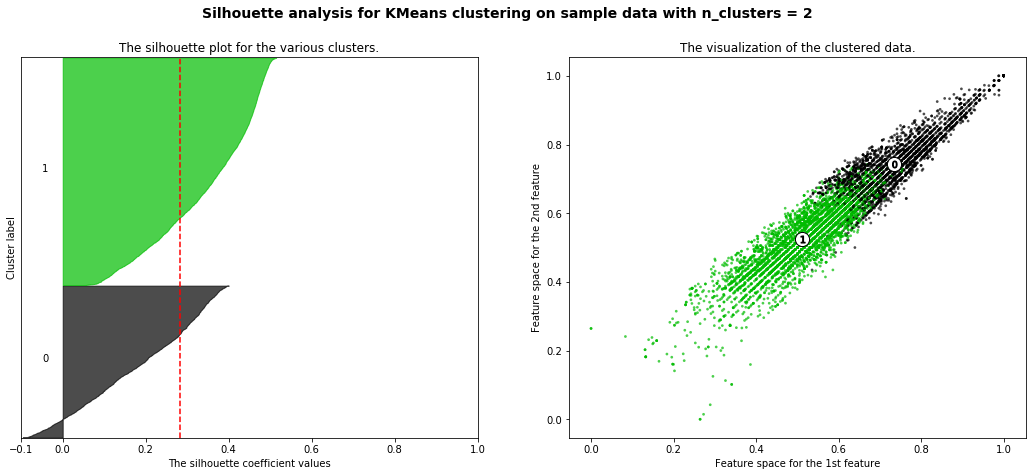

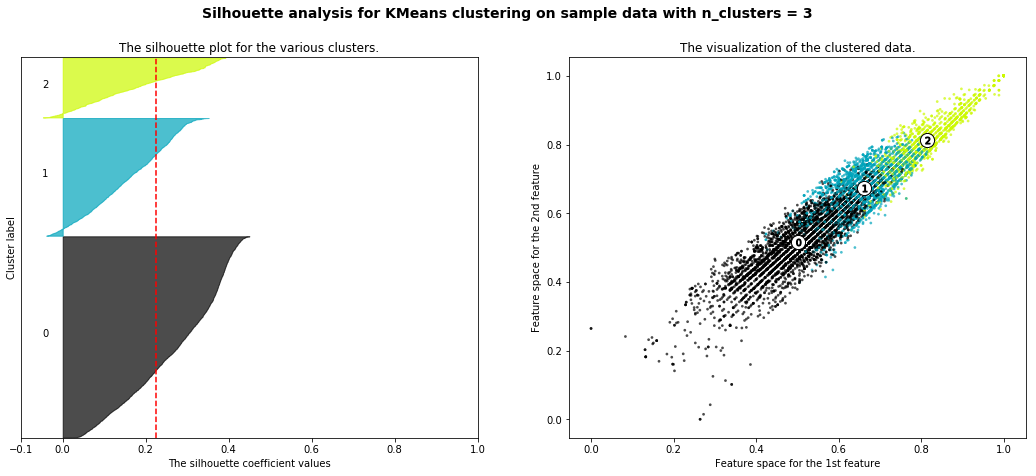

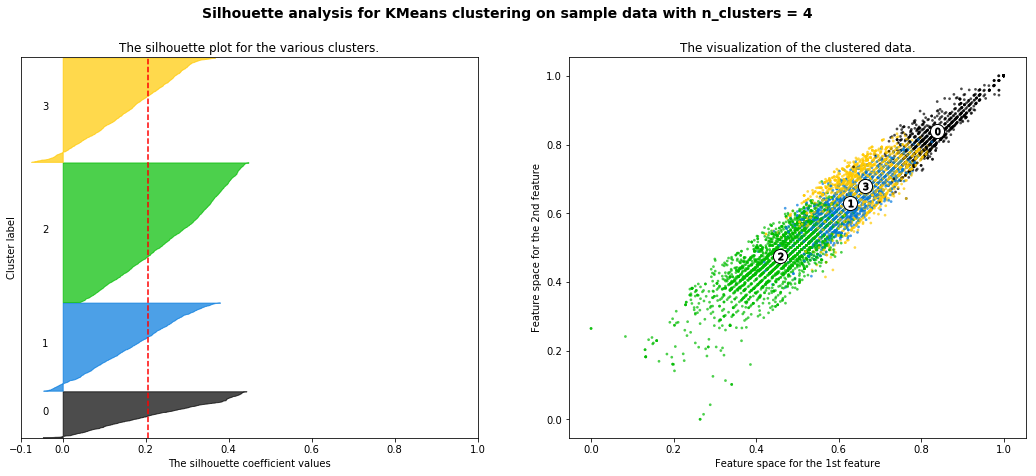

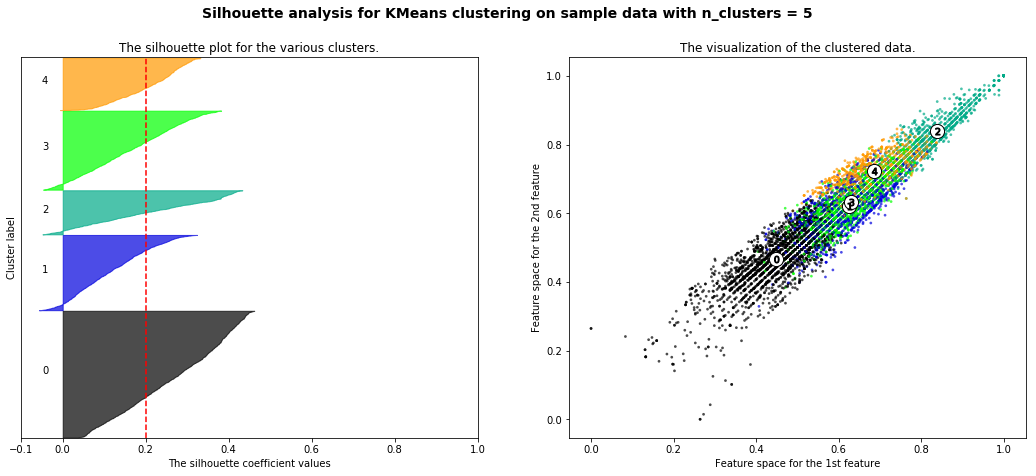

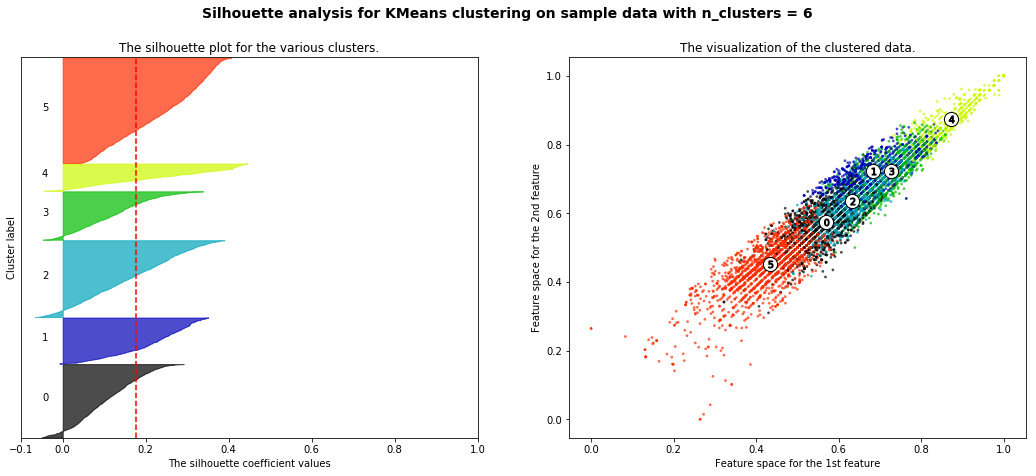

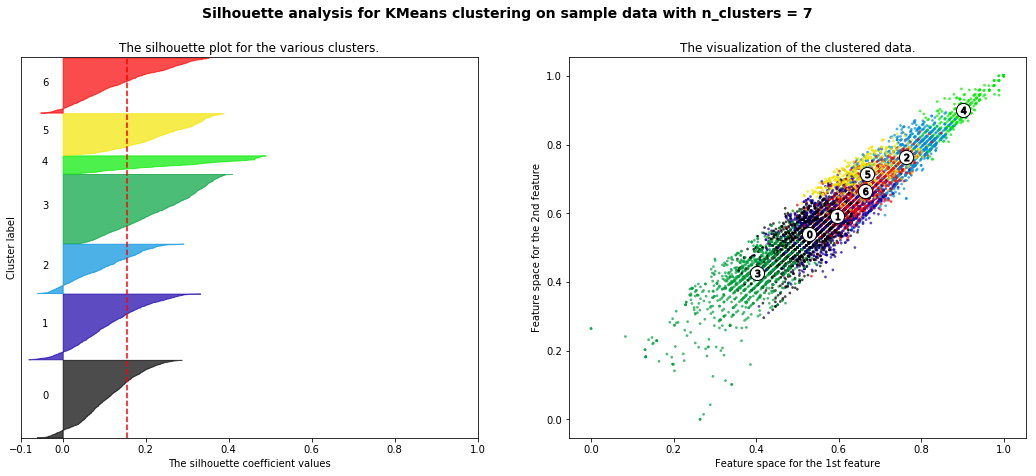

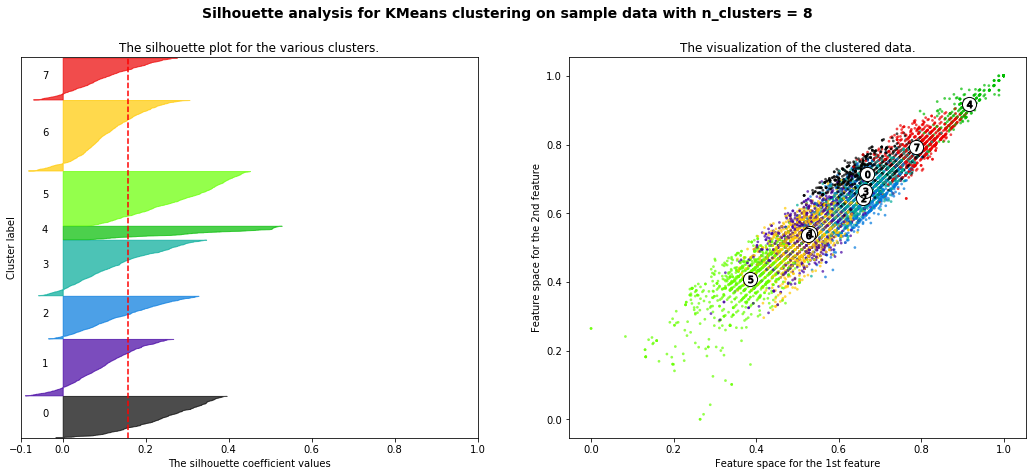

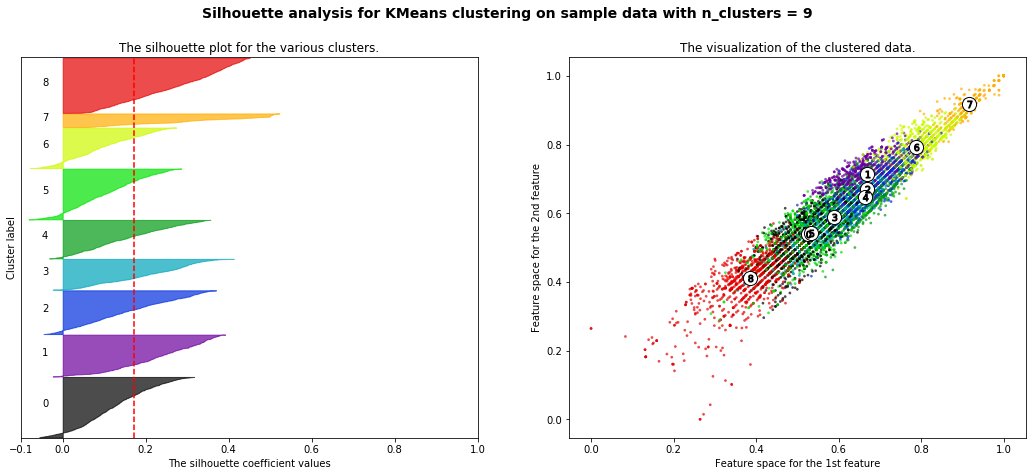

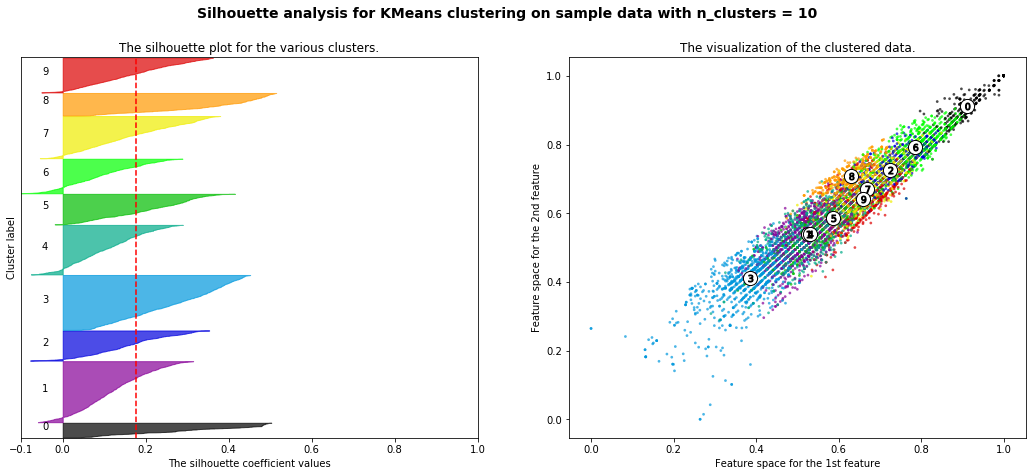

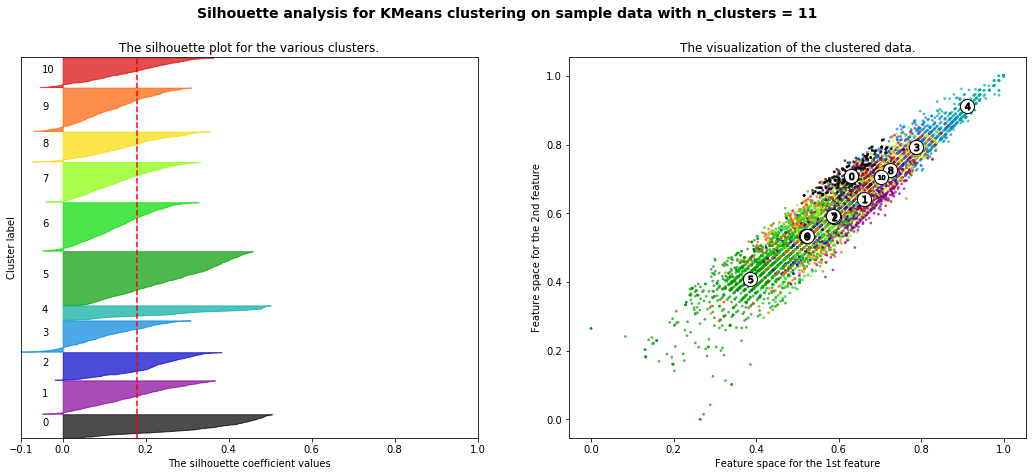

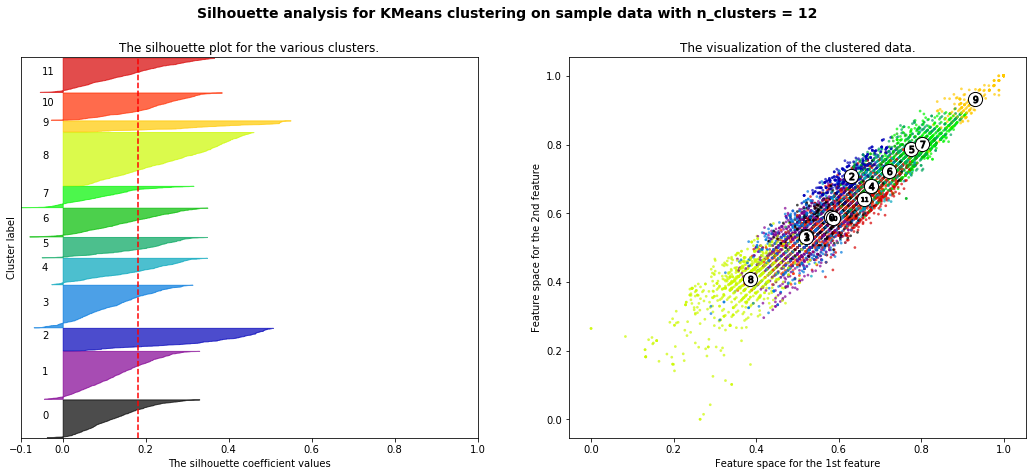

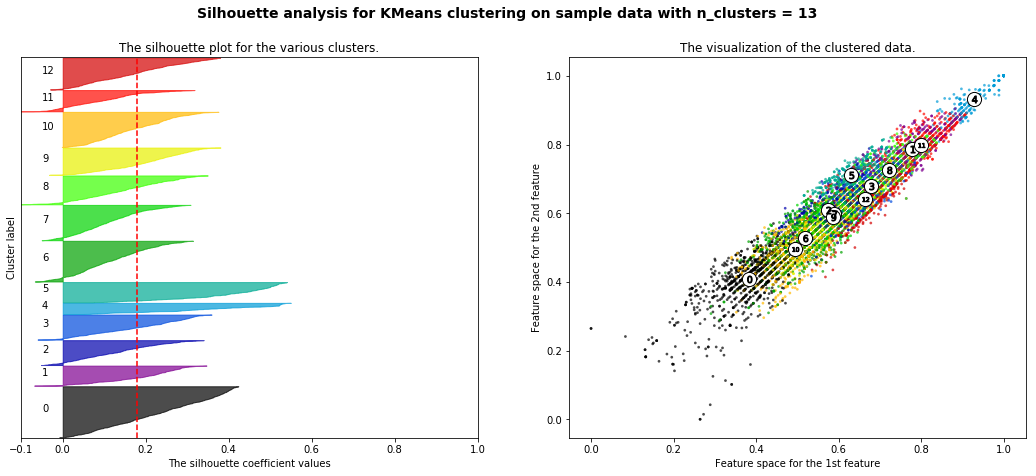

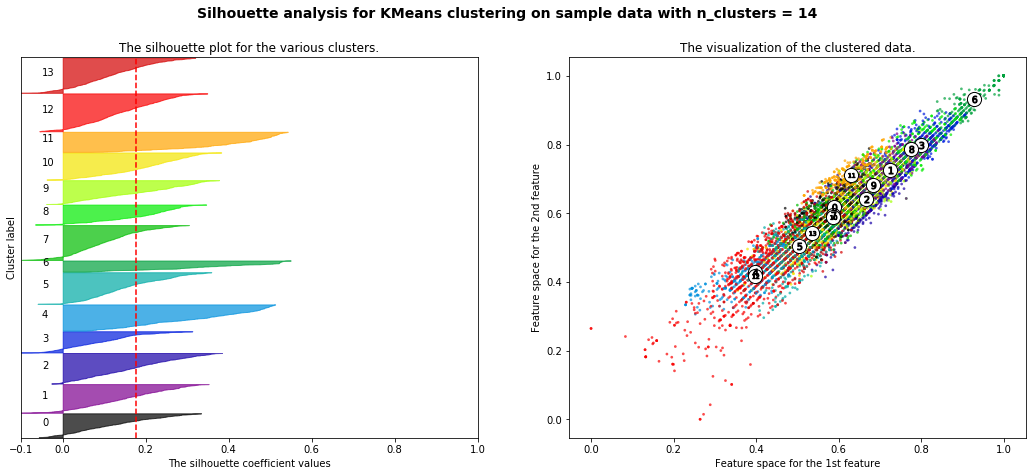

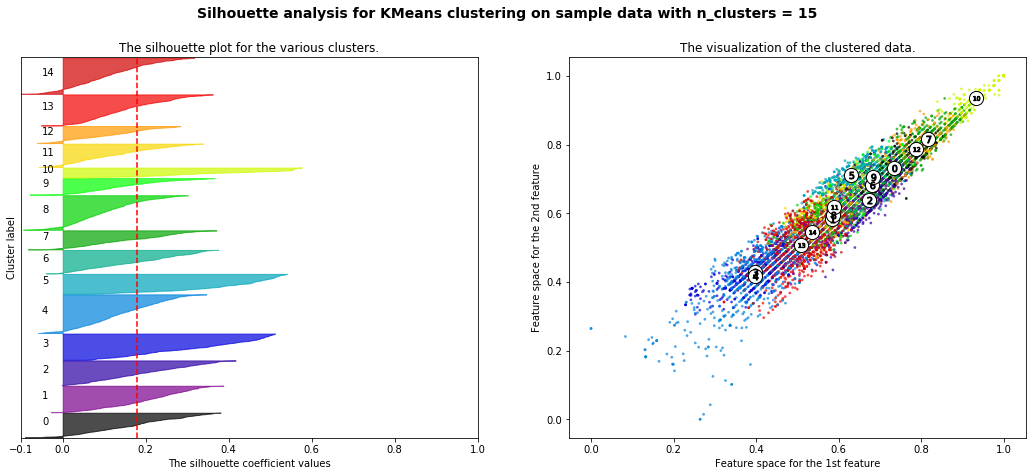

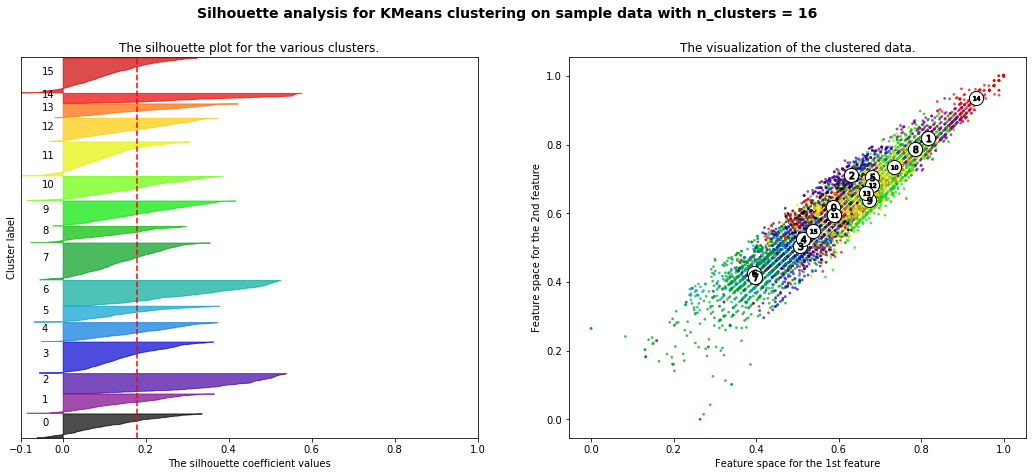

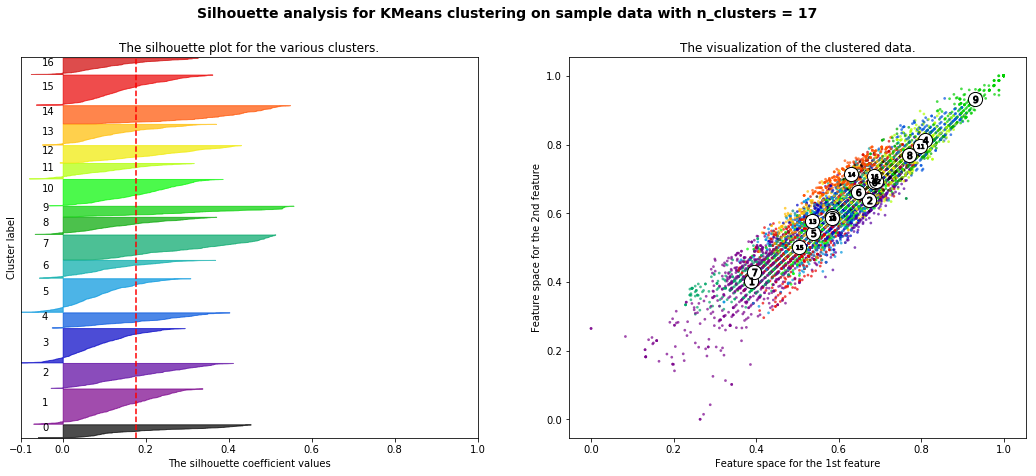

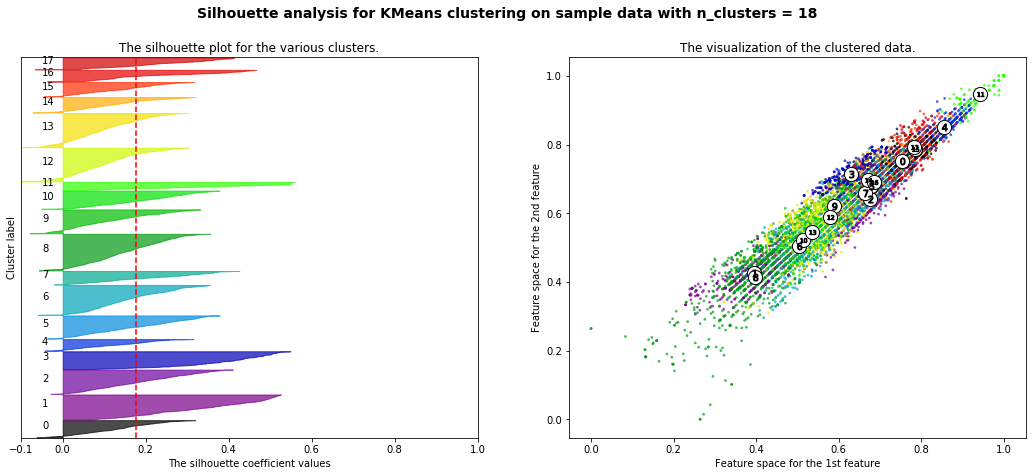

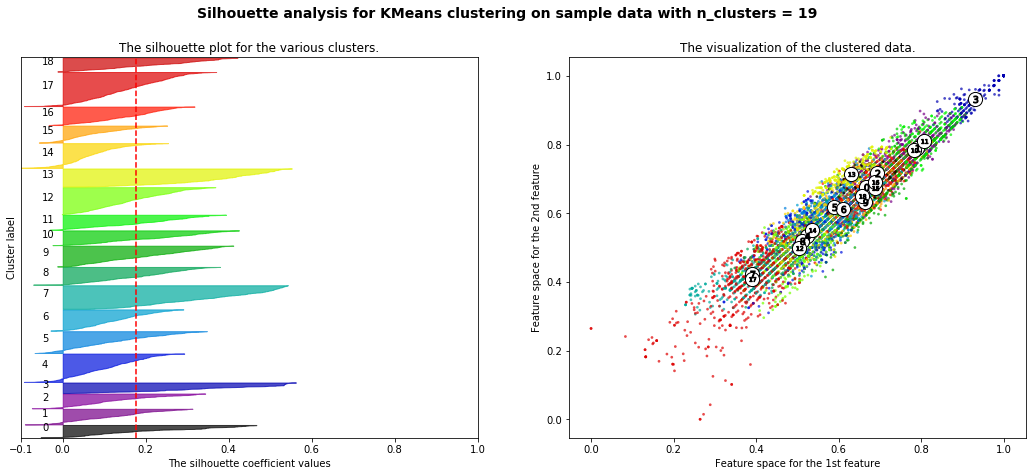

In [42]:

for n_clusters in range(2,20):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dist_array) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dist_array)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dist_array, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dist_array, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dist_array[:, 0], dist_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")  

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
  
plt.show()

## K-means Elbow Curve

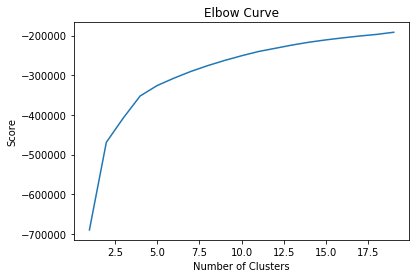

In [21]:
import pylab as pl
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

score = [kmeans[i].fit(dm).score(dm) for i in tqdm(range(len(kmeans)))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

# Clustering using Butina

In [15]:
sim_count = {}
for i in range(len(dm)):
    count = 0
    for j in range(len(dm[i])):
        if dm[i][j] >= 0.9:
            count+=1
    sim_count[i] = count

In [41]:
fps_drug = {}
fps = []
drugs = []
for drug, mol in tqdm(mols_dict.items()):
    fp = MACCSkeys.GenMACCSKeys(mol)
    fps.append(fp)
    drugs.append(drug)
    fps_drug[drug] = fp

In [8]:
dists = []
nfps = len(fps)
for i in tqdm(range(1,nfps)):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
    dists.extend([1-x for x in sims])

In [53]:
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
cs = Butina.ClusterData(dists,nfps,0.3,isDistData=True)


In [60]:
df = pd.DataFrame(columns = ['PubchemID', 'Cluster'])

In [61]:
i=1
j=1
clusters = {}
for cluster in cs:
    for drug in cluster:
        df.loc[i] = [drugs[drug-1]] + [j]
        i+=1
    j+=1

In [63]:
df.to_csv('C:\\Users\\Rana Aldisi\\Desktop\\Clustered_chemicals.csv', index=False)